In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    "green1": "#66c2a5",
    "orange": "#fc8d62",
    "blue": "#8da0cb",
    "pink": "#e78ac3",
    "green2": "#a6d854",
    "yellow": "#ffd92f",
    "brown": "#e5c494",
    "grey": "#b3b3b3",
}

In [3]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [4]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59723.65 # t_0 in salt3
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


### IPAC velocity calculator

- $z=0.02736$, $v = cz = 8202.3$ km/s, $v_\mathrm{CMB} = 8346.4$ km/s

### Cosmic flow

- $\Omega_M=0.3$, $h_0=0.7$

In [5]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

mu = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(mu))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [6]:
import pandas as pd
from astropy.table import Table

In [7]:
# UVOT
joj_UVOT = pd.read_csv(
    "./UVOT_light_curve.dat",
    delimiter=" ",
    names=[
        "time",
        "mag",
        "mag_unc",
        "mag_AB",
        "mag_AB_unc_u",
        "mag_AB_unc_l",
        "lim",
        "band",
    ],
)

In [8]:
set(np.round(joj_UVOT["mag"] - joj_UVOT["mag_AB"], 2))

{-1.73, -1.69, -1.51, -1.02, 0.01, 0.13}

In [9]:
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"]
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"]
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"]
joj_UVOT_uvw1 = joj_UVOT[joj_UVOT["band"] == "UW1"]
joj_UVOT_uvw2 = joj_UVOT[joj_UVOT["band"] == "UW2"]
joj_UVOT_uvm2 = joj_UVOT[joj_UVOT["band"] == "UM2"]
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"].assign(band="uvot::u")
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"].assign(band="uvot::b")
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"].assign(band="uvot::v")
joj_UVOT = pd.concat([joj_UVOT_b, joj_UVOT_v])

In [10]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    """
    calculate the color using multi-band photometry

    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude/flux
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    """
    t1, t2 = X[:, 0], Y[:, 0]
    if not flux:
        mag1, mag2 = X[:, 1], Y[:, 1]
        mag_unc1, mag_unc2 = X[:, 2], Y[:, 2]
        f1, f2 = 10 ** (-0.4 * mag1), 10 ** (-0.4 * mag2)
        f_unc1 = f1 / (2.5 / np.log(10) / mag_unc1)
        f_unc2 = f2 / (2.5 / np.log(10) / mag_unc2)
    else:
        f1, f2 = X[:, 1], Y[:, 1]
        f_unc1, f_unc2 = X[:, 2], Y[:, 2]
    i, j = 0, 0
    T = []
    dmag, Unc_u, Unc_l = [], [], []
    while i < len(t1):
        while j < len(t2):
            if t2[j] >= t1[i] + bin_size:
                break
            if np.abs(t2[j] - t1[i]) < bin_size:
                if f1[i] <= f_unc1[i] or f2[j] <= f_unc2[j]:
                    j += 1
                    continue
                f12 = f1[i] / f2[j]
                f12unc = (
                    f12
                    * ((f_unc1[i] / f1[i]) ** 2 + (f_unc2[j] / f2[j]) ** 2) ** 0.5
                )
                t = (t1[i] / f_unc1[i] ** 2 + t2[j] / f_unc2[j] ** 2) / (
                    1 / f_unc1[i] ** 2 + 1 / f_unc2[j] ** 2
                )
                T = np.append(T, t)
                dmag = np.append(dmag, -2.5 * np.log10(f12))
                Unc_u = np.append(Unc_u, -2.5 * np.log10(f12 / (f12 + f12unc)))
                Unc_l = np.append(Unc_l, -2.5 * np.log10((f12 - f12unc) / f12))
                break
            j += 1
        i += 1
    arg = np.argwhere(Unc_l < 999).flatten()
    return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [11]:
leff_uvot_uvw2 = 2075.69
leff_uvot_uvm2 = 2246.56
leff_uvot_uvw1 = 2715.68
leff_uvot_u = 3523.78
leff_uvot_b = 4345.96
leff_uvot_v = 5412.38
# b - v
b_v = mag1_mag2(
    X=np.array([joj_UVOT_b["time"], joj_UVOT_b["mag"], joj_UVOT_b["mag_unc"]]).T,
    Y=np.array([joj_UVOT_v["time"], joj_UVOT_v["mag"], joj_UVOT_v["mag_unc"]]).T,
    bin_size=0.5,
)
print(
    "b - v = {:.2f} - {:.2f} + {:.2f}".format(
        b_v[1][-1]
        - (
            calALambda(wv=leff_uvot_b, RV=3.1, EBV=ebv)
            - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
        ),
        b_v[2][0][-1],
        b_v[2][1][-1],
    )
)

# u - v
u_v = mag1_mag2(
    X=np.array([joj_UVOT_b["time"], joj_UVOT_u["mag"], joj_UVOT_u["mag_unc"]]).T,
    Y=np.array([joj_UVOT_v["time"], joj_UVOT_v["mag"], joj_UVOT_v["mag_unc"]]).T,
    bin_size=0.5,
)
print(
    "u - v = {:.2f} - {:.2f} + {:.2f}".format(
        u_v[1][-1]
        - (
            calALambda(wv=leff_uvot_u, RV=3.1, EBV=ebv)
            - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
        ),
        b_v[2][0][-1],
        b_v[2][1][-1],
    )
)

# uvw1 - v
uvw1_v = mag1_mag2(
    X=np.array(
        [joj_UVOT_uvw1["time"], joj_UVOT_uvw1["mag"], joj_UVOT_uvw1["mag_unc"]]
    ).T,
    Y=np.array([joj_UVOT_v["time"], joj_UVOT_v["mag"], joj_UVOT_v["mag_unc"]]).T,
    bin_size=0.5,
)
print(
    "uvw1 - v = {:.2f} - {:.2f} + {:.2f}".format(
        uvw1_v[1][-1]
        - (
            calALambda(wv=leff_uvot_uvw1, RV=3.1, EBV=ebv)
            - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
        ),
        uvw1_v[2][0][-1],
        uvw1_v[2][1][-1],
    )
)

# uvm2 - uvw1
uvm2_uvw1 = mag1_mag2(
    X=np.array(
        [joj_UVOT_uvm2["time"], joj_UVOT_uvm2["mag"], joj_UVOT_uvm2["mag_unc"]]
    ).T,
    Y=np.array(
        [joj_UVOT_uvw1["time"], joj_UVOT_uvw1["mag"], joj_UVOT_uvw1["mag_unc"]]
    ).T,
    bin_size=0.5,
)
print(
    "uvm2 - uvw1 = {:.2f} - {:.2f} + {:.2f}".format(
        uvm2_uvw1[1][-1]
        - (
            calALambda(wv=leff_uvot_uvw1, RV=3.1, EBV=ebv)
            - calALambda(wv=leff_uvot_v, RV=3.1, EBV=ebv)
        ),
        uvm2_uvw1[2][0][-1],
        uvm2_uvw1[2][1][-1],
    )
)

b - v = 0.04 - 0.06 + 0.06
u - v = 0.58 - 0.06 + 0.06
uvw1 - v = 2.48 - 0.17 + 0.20
uvm2 - uvw1 = 1.59 - 0.36 + 0.55


In [12]:
joj_UVOT_b["mag"].min() - mu - calALambda(
    wv=leff_uvot_b, RV=3.1, EBV=ebv
), joj_UVOT_b.loc[joj_UVOT_b.index[joj_UVOT_b["mag"].argmin()]]

(-19.514822047838155,
 time            59722.744811
 mag                16.003277
 mag_unc             0.036979
 mag_AB             15.873277
 mag_AB_unc_u        0.030932
 mag_AB_unc_l        0.031839
 lim                        0
 band                 uvot::b
 Name: 19, dtype: object)

In [13]:
joj_UVOT_u["mag"].min() - mu - calALambda(
    wv=leff_uvot_u, RV=3.1, EBV=ebv
), joj_UVOT_u.loc[joj_UVOT_u.index[joj_UVOT_u["mag"].argmin()]]

(-18.991662583538634,
 time            59720.060356
 mag                16.550915
 mag_unc             0.058554
 mag_AB             17.570915
 mag_AB_unc_u        0.056031
 mag_AB_unc_l        0.059081
 lim                        0
 band                 uvot::u
 Name: 8, dtype: object)

In [14]:
with open("./UVOT_sample.txt", "r") as f:
    lines = f.readlines()
UVOT_mag_sample = np.empty((5, 28))
UVOT_mag_err_sample = np.empty((5, 28))

k = 0
for line in lines:
    if line.split()[0][0] == '#': continue
    line = line.replace("−", "-")
    line = line.replace("L", "nan")
    dat = line.split()
    mag = [float(d.split("\uf0a0")[0]) for d in dat]
    mag_err = [float(d.split("\uf0a0")[-1]) for d in dat]
    UVOT_mag_sample[k, :] = mag
    UVOT_mag_err_sample[k, :] = mag_err
    k += 1

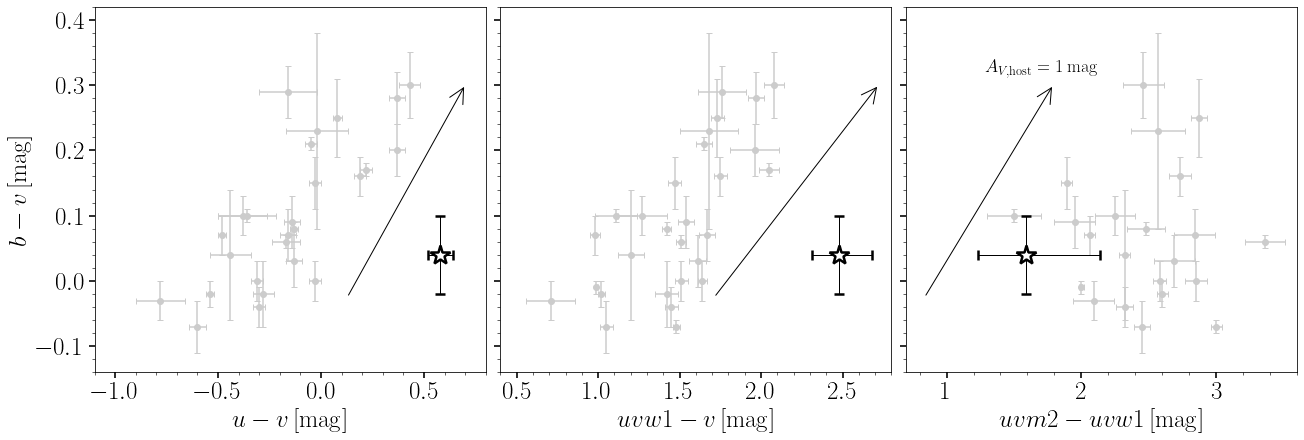

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharey=True)
ax[0].errorbar(
    UVOT_mag_sample[2, :],
    UVOT_mag_sample[1, :],
    fmt="o",
    xerr=UVOT_mag_err_sample[2, :],
    yerr=UVOT_mag_err_sample[1, :],
    capsize=3,
    color="0.8",
)
ax[1].errorbar(
    UVOT_mag_sample[3, :],
    UVOT_mag_sample[1, :],
    fmt="o",
    xerr=UVOT_mag_err_sample[3, :],
    yerr=UVOT_mag_err_sample[1, :],
    capsize=3,
    color="0.8",
)
ax[2].errorbar(
    UVOT_mag_sample[4, :],
    UVOT_mag_sample[1, :],
    fmt="o",
    xerr=UVOT_mag_err_sample[4, :],
    yerr=UVOT_mag_err_sample[1, :],
    capsize=3,
    color="0.8",
)

# b - v = 0.04 - 0.06 + 0.06
# u - v = 0.58 - 0.06 + 0.06
# uvw1 - v = 2.48 - 0.17 + 0.20
# uvm2 - uvw1 = 1.59 - 0.36 + 0.55

color_style = dict(
    fmt="*",
    ms=20,
    color="k",
    capsize=5,
    markerfacecolor="w",
    zorder=10,
    linewidth=1,
    markeredgewidth=2.5,
)
arrow_style = dict(
    arrowprops={"arrowstyle": "->, head_width=.3, head_length=.6", "linestyle": "-", "linewidth":1.},
    text="",
    ha="center",
    va="center",
)

ax[0].errorbar(0.58, 0.04, xerr=0.06, yerr=0.06, **color_style)
ax[0].annotate(
    xy=(0.58 + .12, .3),
    xytext=(
        0.58 + .12
        - (
            calALambda(leff_uvot_u, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
        .3
        - (
            calALambda(leff_uvot_b, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
    ),
    **arrow_style,
)

ax[1].errorbar(2.48, 0.04, xerr=[[0.17], [0.20]], yerr=0.06, **color_style)
ax[1].annotate(
    xy=(2.47 + .25, .3),
    xytext=(
        2.47 + .25
        - (
            calALambda(leff_uvot_uvw1, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
        .3
        - (
            calALambda(leff_uvot_b, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
    ),
    **arrow_style,
)
ax[2].errorbar(1.59, 0.04, xerr=[[0.36], [0.55]], yerr=0.06, **color_style)
ax[2].annotate(
    xy=(1.59 + .2, .3),
    xytext=(
        1.59 + .2
        - (
            calALambda(leff_uvot_uvm2, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_uvw1, EBV=1 / 3.1, RV=3.1)
        ),
        .3
        - (
            calALambda(leff_uvot_b, EBV=1 / 3.1, RV=3.1)
            - calALambda(leff_uvot_v, EBV=1 / 3.1, RV=3.1)
        ),
    ),
    **arrow_style,
)

ax[2].text(
    1.7, 0.32, r"$A_{V,\mathrm{host}} = 1\,\mathrm{mag}$", fontsize=18, ha="center"
)

ax[0].set_xlabel("$u - v\,[\mathrm{mag}]$")
ax[1].set_xlabel("$uvw1 - v\,[\mathrm{mag}]$")
ax[2].set_xlabel("$uvm2 - uvw1\,[\mathrm{mag}]$")
ax[0].set_ylabel("$b - v\,[\mathrm{mag}]$")

for a in ax[:2]:
    a.xaxis.set_major_locator(MultipleLocator(.5))
    a.xaxis.set_minor_locator(MultipleLocator(.1))
ax[2].xaxis.set_major_locator(MultipleLocator(1))
ax[2].xaxis.set_minor_locator(MultipleLocator(.2))

ax[0].set_xlim(-1.1, 0.8)
ax[1].set_xlim(0.4, 2.8)
ax[2].set_xlim(0.7, 3.6)

ax[0].yaxis.set_minor_locator(MultipleLocator(0.02))
ax[0].set_ylim(-0.14, 0.42)

plt.savefig("../paper/figures/UVOT_colors.pdf", bbox_inches="tight")